In [1]:
import os

import matplotlib.pyplot as plt
from matplotlib.colors import LightSource
import numpy as np
import open3d as o3d
import seaborn as sns

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
%matplotlib widget

In [3]:
# constants
elev = 25
azim = 50
colors = sns.color_palette('colorblind', 3)
colors

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)]

In [4]:
# data
fname = os.path.join('data', 'model', 'head.scaled')
points = np.loadtxt(fname + '.xyz') 
normals = np.loadtxt(fname + '.normals')
mesh = o3d.io.read_triangle_mesh(fname + '.iso.watertight.off')
vert = np.asarray(mesh.vertices)
tri = np.asarray(mesh.triangles)

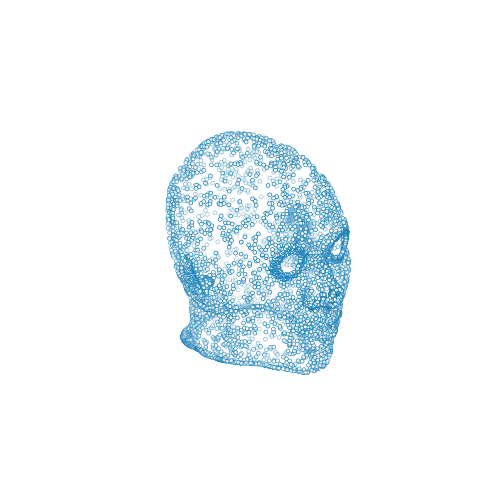

In [5]:
# point cloud
N = points.shape[0]
num = 0.1 * N
mask = np.arange(0, N, int(N/num))

plt.close()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.scatter(*points[mask].T,
           fc='w', ec=colors[0], s=7.5, lw=0.5)
ax.set_box_aspect(np.ptp(points, axis=0))
ax.set_axis_off()
ax.view_init(elev, azim)
plt.show()

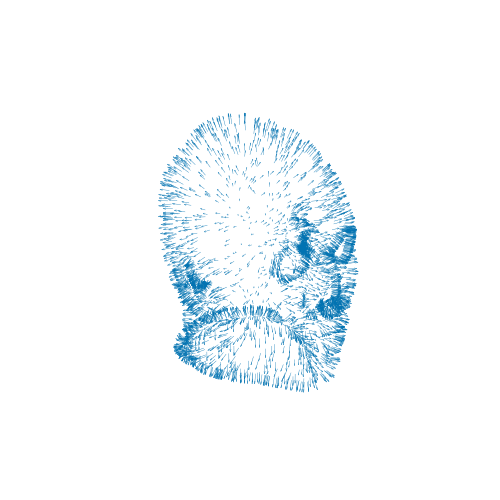

In [6]:
# normals
N = points.shape[0]
num = 0.05 * N
mask = np.arange(0, N, int(N/num))

plt.close()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.quiver(*points[mask].T, *normals[mask].T,
          color=colors[0], normalize=True, lw=0.25)
ax.set_box_aspect(np.ptp(points, axis=0))
ax.set_axis_off()
ax.view_init(elev, azim)
plt.show()

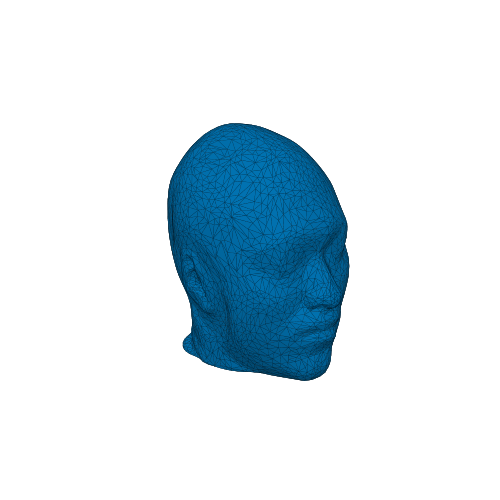

In [7]:
# surface
mesh_smp = mesh.simplify_quadric_decimation(6500)
vert_smp = np.asarray(mesh_smp.vertices)
tri_smp = np.asarray(mesh_smp.triangles)
ls = LightSource(elev+20, azim)

plt.close()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.plot_trisurf(*vert_smp.T, triangles=tri_smp,
                color=colors[0], lw=0.05, ec='k', lightsource=ls)
ax.set_box_aspect(np.ptp(points, axis=0))
ax.set_axis_off()
ax.view_init(elev, azim)
plt.show()

# pspd -- wip

In [6]:
from scipy import spatial
from tqdm.auto import tqdm

from pspd.points import remove_hidden_points
from pspd.misc import edblquad

In [7]:
query_point = points[points[:, 0].argmax(), :]
dist = np.linalg.norm((points - query_point) / np.array([1, 0.5, 0.25]),
                      axis=1)
r = 2.5
I0 = 10
pd = I0 * np.exp(-(dist / r) ** 2)

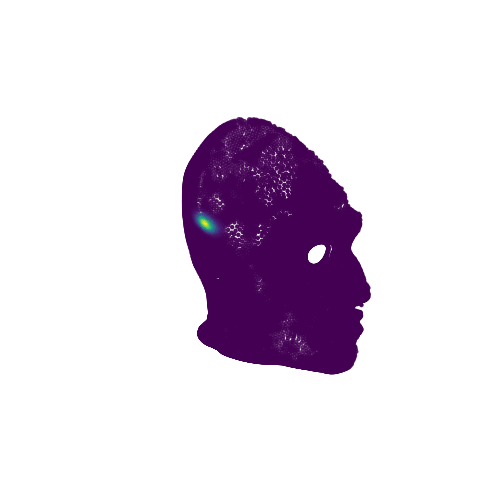

In [8]:
pov = np.mean(points, axis=0)
diameter = np.linalg.norm(points.ptp(axis=0))
pov[0] += 2 * diameter
pov[1] += 0.5 * diameter
ind = remove_hidden_points(points, pov, np.pi)

plt.close()
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.scatter(*points[ind].T, c=pd[ind], s=1)
ax.set_box_aspect(np.ptp(points[ind], axis=0))
ax.set(xlabel='x', ylabel='y')
ax.set_axis_off()
ax.view_init(elev, azim)
plt.show()

In [9]:
A = 4  # projected averaging area
a = np.sqrt(A)  # side length of the projected averaging surface
rc = np.sqrt(2) / 2 * a  # radius of the circumscribed circle of a square of area A

# results data-placeholder
res = {'p': [],
       'nbh': [],
       'nbh_mesh': [],
       'area': [],
       'pd': [],
       'spd': []}

res.fromkeys(res, [])  # reset values for each new run

pc_tree = spatial.KDTree(points)  # k-d tree for point cloud data
vert_tree = spatial.KDTree(vert)  # k-d tree for mesh vertices

In [17]:
if isinstance(mesh, o3d.geometry.PointCloud):
    pass
else:
    print('Unrecognized mesh format. Proceeding without mesh.')

Unrecognized mesh format. Proceeding without mesh.


In [14]:
isinstance(mesh, o3d.geometry.PointCloud)

False

In [18]:
# run only for the "visible" set of points from the POV of the EM source
for p in tqdm(points[ind]):
    # p = query_point.copy()
    # extract points from the point cloud within the radius rc of a query point
    _nbh_ind = pc_tree.query_ball_point([p], rc, workers=-1)[0]
    _nbh = points[_nbh_ind]
    _n = normals[_nbh_ind]
    _pd = pd[_nbh_ind]
    
    # select vertices fromm the mesh withing the radius rc of a qery point
    _vert_ind = vert_tree.query_ball_point([p], rc, workers=-1)[0]
    _mesh = mesh.select_by_index(_vert_ind, cleanup=True)
    _mesh = _mesh.subdivide_midpoint(number_of_iterations=1)
    _vert = np.asarray(_mesh.vertices)
    
    # map a local point cloud into an orthonormal basis
    X = _nbh.copy()
    mu = X.mean(axis=0)
    Xn = X - mu
    pn = p - mu
    Vn = _vert - mu
    C = Xn.T @ Xn
    U, _, _ = np.linalg.svd(C)
    Xt = Xn @ U
    pt = pn @ U
    Vt = Vn @ U
    
    # set the bounding box that corresponds to the projected square area for averaging
    _bbox = [pt[0]-a/2, pt[0]+a/2,
             pt[1]-a/2, pt[1]+a/2]
    _Xt_bbox_ind = np.where((Xt[:, 0] >= _bbox[0])
                            & (Xt[:, 0] <= _bbox[1])
                            & (Xt[:, 1] >= _bbox[2])
                            & (Xt[:, 1] <= _bbox[3]))[0]
    _Vt_bbox_ind = np.where((Vt[:, 0] >= _bbox[0])
                            & (Vt[:, 0] <= _bbox[1])
                            & (Vt[:, 1] >= _bbox[2])
                            & (Vt[:, 1] <= _bbox[3]))[0]
    
    # estimate the conformal surface area
    _nbh_mesh = _mesh.select_by_index(_Vt_bbox_ind, cleanup=True)
    _area = _nbh_mesh.get_surface_area()
        
    # estimate the spatially-averaged absorbed power density
    _spd = 1 / _area * edblquad(points=Xt[_Xt_bbox_ind, :2],
                                values=_pd[_Xt_bbox_ind],
                                bbox=_bbox,
                                s=1)

    # capture the rest of the values results
    _nbh = _nbh[_Xt_bbox_ind]
    _n = _n[_Xt_bbox_ind]
    _pd = _pd[_Xt_bbox_ind]
    
    # store the results
    res['p'].append(p)
    res['nbh'].append(_nbh)
    res['nbh_mesh'].append(_nbh_mesh)
    res['area'].append(_area)
    res['pd'].append(_pd)
    res['spd'].append(_spd)

  0%|          | 0/24995 [00:00<?, ?it/s]

IndexError: index 105 is out of bounds for axis 0 with size 105

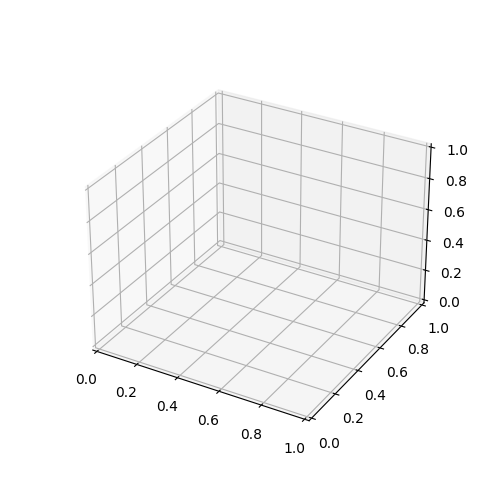

In [73]:
# surface
ls = LightSource(elev, azim)
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.scatter(*_nbh[_Xt_bbox_ind].T, color=colors[0])
ax.plot_trisurf(*np.asarray(_nbh_mesh.vertices).T,
                triangles=np.asarray(_nbh_mesh.triangles),
                color=colors[2], alpha=0.75, lightsource=ls)
ax.set_box_aspect(_mesh.get_max_bound() - _mesh.get_min_bound())
#ax.set_axis_off()
ax.view_init(elev, azim)
plt.show()

In [19]:
pi = np.argmax(res['spd'])
pp = res['p'][pi]
pnbh = res['nbh'][pi]
pnbh_mesh = res['nbh_mesh'][pi]
parea = res['area'][pi]
ppd = res['pd'][pi]
pspd = res['spd'][pi]

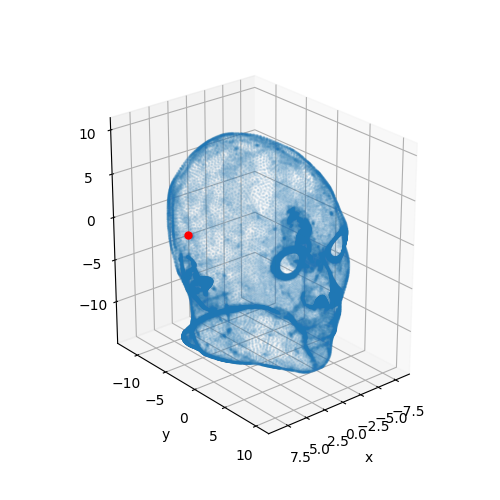

In [20]:
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.scatter(*points.T, alpha=0.1, s=1)
ax.plot(*pp, 'ro', ms=5, zorder=3)
ax.set_box_aspect(np.ptp(points, axis=0))
ax.set(xlabel='x', ylabel='y')
ax.view_init(25, 50)
plt.show()

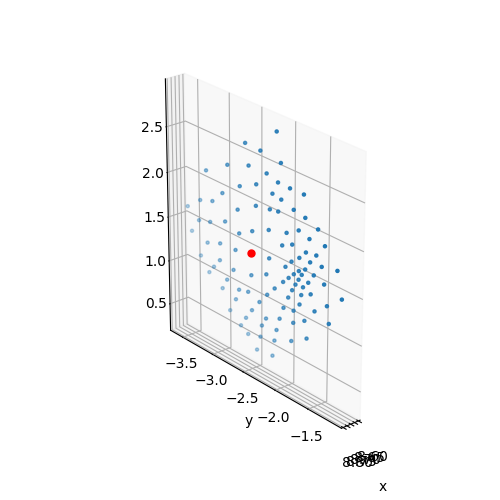

In [21]:
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.scatter(*pnbh.T, s=5)
ax.plot(*pp, 'ro', ms=5, zorder=3)
ax.set_box_aspect(np.ptp(pnbh, axis=0))
ax.set(xlabel='x', ylabel='y')
ax.view_init(25, 50)
plt.show()

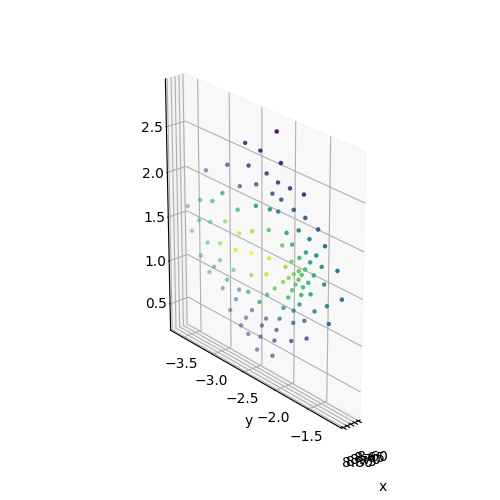

In [22]:
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.scatter(*pnbh.T, c=ppd, s=5)
ax.set_box_aspect(np.ptp(pnbh, axis=0))
ax.set(xlabel='x', ylabel='y')
ax.view_init(25, 50)
plt.show()

In [24]:
pvert = np.asarray(pnbh_mesh.vertices)
ptri = np.asarray(pnbh_mesh.triangles)

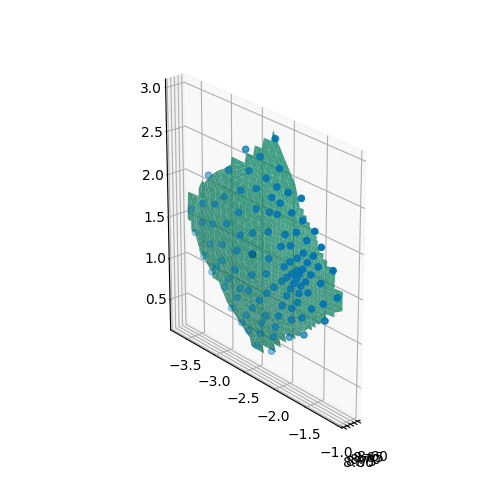

In [25]:
# surface
ls = LightSource(elev, azim)
fig = plt.figure(figsize=(5, 5))
ax = plt.axes(projection='3d')
ax.scatter(*pnbh.T, color=colors[0])
ax.scatter(*pp, color='k')
ax.plot_trisurf(*pvert.T, triangles=ptri, color=colors[2], alpha=0.75, lightsource=ls)
ax.set_box_aspect(np.ptp(pvert, axis=0))
#ax.set_axis_off()
ax.view_init(elev, azim)
plt.show()

In [26]:
pspd

5.068689590412292

In [27]:
parea

3.620591225272984